In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal

In [2]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [3]:
###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

# ##########################
# ### Apply notch filter ###
# ##########################

# outputSignal = signal.filtfilt(b_notch, a_notch, signal_corrupt)

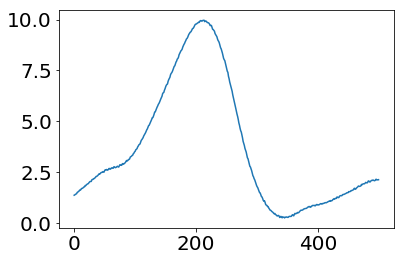

In [4]:
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior"
#main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/corrected"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)

responses_split = np.reshape(responses, (49-18,2000,4,500))
responses_notch = signal.filtfilt(b_notch, a_notch, responses_split, axis=-1)

cluster_id = np.argmax(np.sum(responses_notch[20,:,0,:].real, axis=1))
plt.plot(responses_notch[20,cluster_id,0,:])

In [128]:
# 250 points is 5sec
5/250
# 20ms per point

0.02

In [126]:
all_signals_unfiltered = np.reshape(responses_split[:,:,:,:],(31*2000,4,500))
all_signals = np.reshape(responses_notch,(31*2000,4,500))

all_maxs = np.max(np.abs(all_signals),axis=-1)
thresholds = np.percentile(all_maxs,60,axis=0)

peaks = {}
peaks_ms = {}
peaks_unfiltered = {}
thresholded_filters_norm = {}
thresholded_filters_norm_unfiltered = {}
to_delete = {}
decay_times = {}
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    to_delete_ = np.where(all_maxs[:,beh_idx]<thresholds[beh_idx])
    thresholded_filters = np.delete(all_signals[:,beh_idx,:], to_delete_, axis=0)
    
    # add gaussian smoothing
    thresholded_filters = gaussian_filter1d(thresholded_filters,sigma=2,axis=-1)
    
    peaks_ = np.argmax(thresholded_filters,axis=-1)
    #idx_sort = np.argsort(peaks)
    maxs = np.max(thresholded_filters,axis=-1)
    thresholded_filters_norm_ = thresholded_filters/maxs[:,np.newaxis]
        
    peaks[beh_idx] = peaks_
    peaks_ms[beh_idx] = (peaks_-250)*20
    thresholded_filters_norm[beh_idx] = thresholded_filters_norm_
    to_delete[beh_idx] = to_delete_
    
    thresholded_filters_unfiltered = np.delete(all_signals_unfiltered[:,beh_idx,:], to_delete_, axis=0)
    maxs = np.max(thresholded_filters_unfiltered,axis=-1)
    thresholded_filters_norm_ = thresholded_filters_unfiltered/maxs[:,np.newaxis]
    thresholded_filters_norm_unfiltered[beh_idx] = thresholded_filters_norm_
    
    peaks_ = np.argmax(thresholded_filters_unfiltered,axis=-1)
    peaks_unfiltered[beh_idx] = peaks_
    
    # add tau finding
    decay_times_ = []
    decay_amount = .5
    for i in range(len(peaks[beh_idx])):
        trace = thresholded_filters_norm[beh_idx][i,:]
        try:
            decay_time = np.where((np.where(trace<decay_amount)[0] < peaks[beh_idx][i]) == False)[0][0]-1
        except:
            decay_time = 0
        decay_times_.append(decay_time)
    decay_times[beh_idx] = decay_times_

0
1
2
3


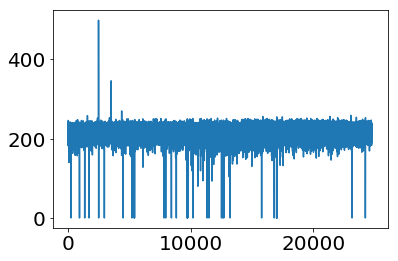

In [108]:
plt.plot(peaks[1])

In [104]:
peaks[beh_idx][i]

499

In [103]:
np.where(trace<.5)[0]

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
       301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
       314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
       327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
       340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
       353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
       366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
       379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417,
       418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 42

In [100]:
len(peaks[0])

24800

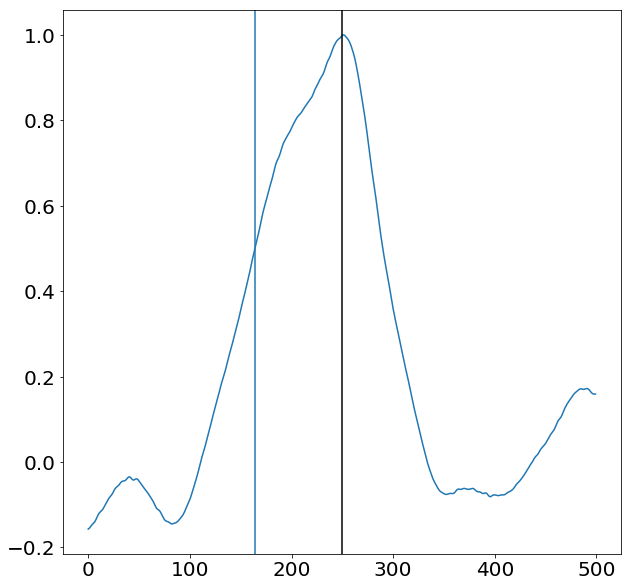

In [36]:
plt.figure(figsize=(10,10))
#plt.plot(thresholded_filters_norm[0][:1000,:].T);
trace = thresholded_filters_norm[0][:,:][peaks[0][:] > 250].T[:,0]
plt.plot(trace)
#plt.plot(thresholded_filters_norm[0][:,:][peaks[0][:] > 250].T)

#plt.plot(temp)
plt.axvline(250,color='k')
# plt.xlim(200,300)
# plt.ylim(.8,1.1)
plt.axvline(164)

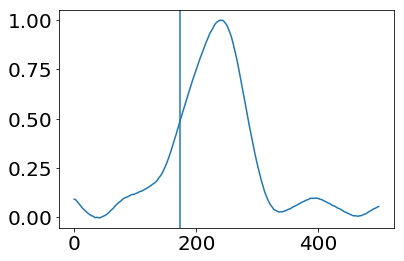

In [83]:
idx = 4000
plt.plot(thresholded_filters_norm[0][idx,:])
plt.axvline(decay_times[idx])

In [69]:
thresholded_filters_norm[0].shape

(24800, 500)

In [78]:
### Good code ###

decay_times = []
for i in range(24800):
    trace = thresholded_filters_norm[0][i,:]
    decay_time = np.where((np.where(trace<.5)[0] < peaks[0][i]) == False)[0][0]-1
    decay_times.append(decay_time)

In [71]:
trace.shape

(500,)

In [6]:
thresholded_filters_norm_.shape

(24800, 500)

In [68]:
24800*500

12400000

In [54]:
np.shape(np.where(thresholded_filters_norm_<.5))

(2, 9859448)

In [67]:
peaks[0].shape

(24800,)

In [66]:
np.where(thresholded_filters_norm_<.5) 

(array([    0,     0,     0, ..., 24799, 24799, 24799]),
 array([  0,   1,   2, ..., 497, 498, 499]))

In [47]:
np.where(trace<.5)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 290, 291, 292, 293,
        294, 295, 296, 297, 298, 299, 300, 301, 302

In [ ]:
np.where((np.where(trace<.5)[0] < 251) == False)[0][0]-1

In [35]:
np.where((np.where(trace<.5)[0] < 251) == False)[0][0]-1

164

In [18]:
peaks[0][peaks[0][:] > 250]

array([251, 253, 251, 251, 251, 254, 252, 255, 251, 253, 254, 252, 253,
       252, 253, 251, 251, 256, 252, 251, 253, 257, 257, 255, 252, 254,
       255, 258, 253, 252, 253, 258, 252, 255, 255, 251, 255, 253, 255,
       255, 253, 251, 253, 253, 257, 252, 253, 252, 253, 256, 254, 251,
       255, 251, 252, 254, 252, 253, 251, 252, 251, 252, 255, 252, 251,
       252, 251, 259, 251, 253, 257, 255, 254, 252, 251, 251, 255, 251,
       255, 253, 252, 251, 251, 252, 255, 251, 253, 251, 254, 253, 252,
       251, 252, 252, 253, 253, 251, 252, 253, 251, 251, 254, 251, 251,
       252, 251, 253, 251, 254, 253, 253, 252, 253, 251, 253, 251, 252,
       253, 251, 254, 254, 252, 251, 253, 256, 251, 251, 253, 254, 252,
       252, 252, 252, 253, 255, 253, 254, 254, 252, 253, 252, 251, 254,
       252, 254, 256, 252, 251, 251, 252, 253, 253, 253, 253, 254, 253,
       253, 251, 251, 251, 254, 254, 251, 251, 251, 251, 254, 252, 252,
       251, 254, 251, 251, 253, 252, 252, 251, 251, 254, 251, 25

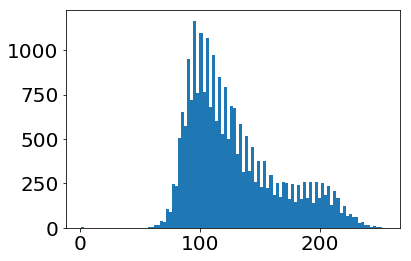

In [119]:
plt.hist(peaks[beh_idx] - decay_times[beh_idx],bins=100);

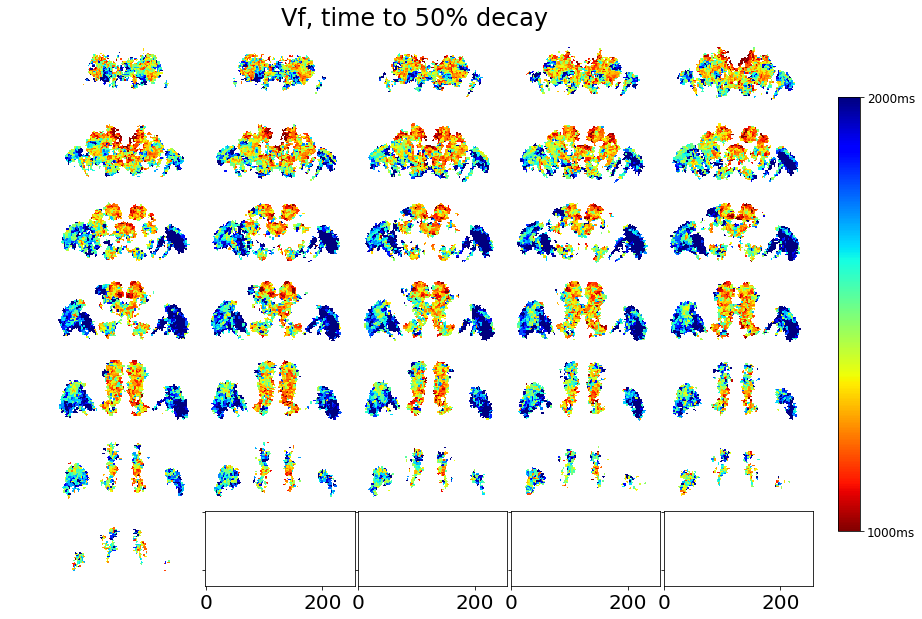

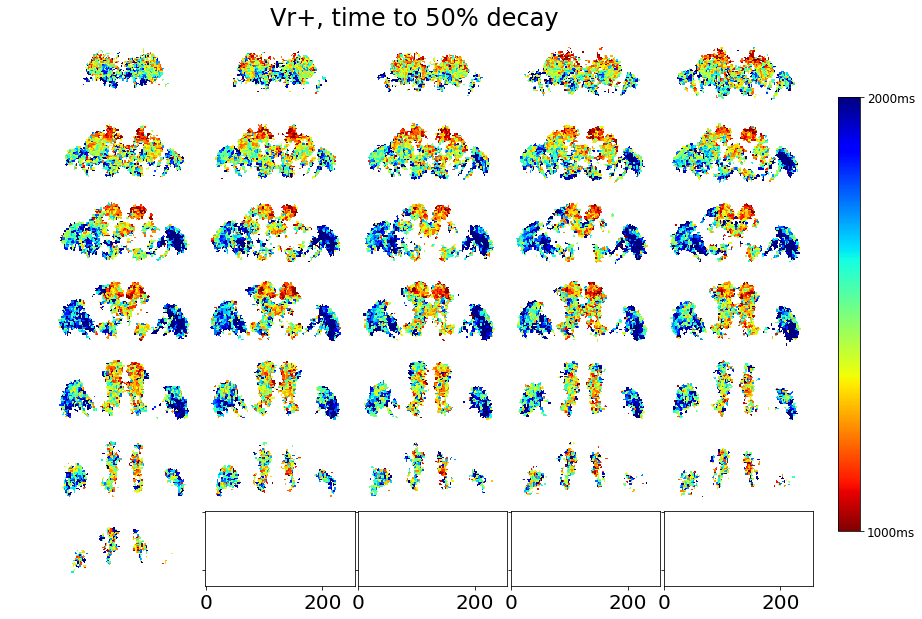

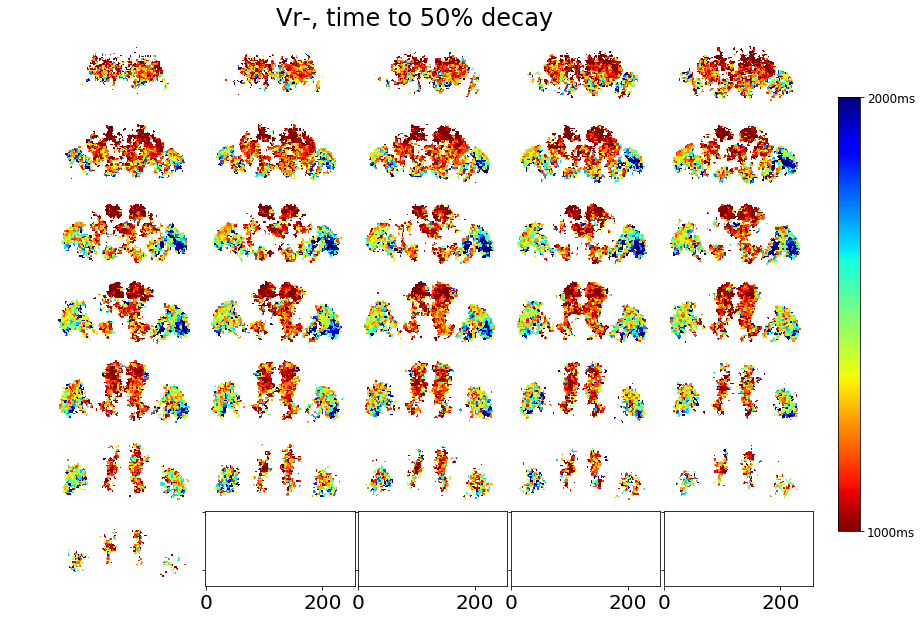

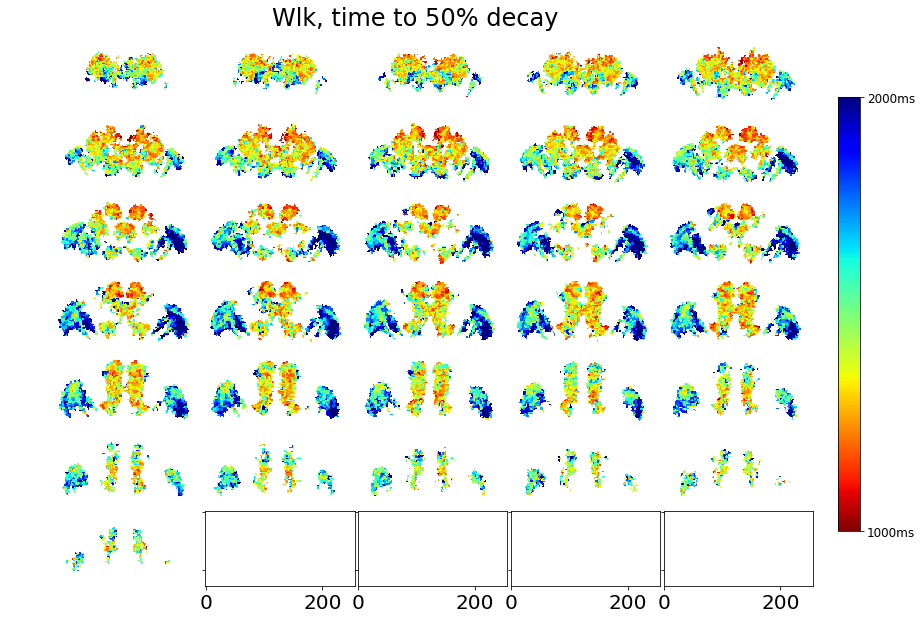

In [132]:
for beh_idx in [0,1,2,3]:
    behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

    add_deleted_voxels = np.zeros(62000)
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    add_deleted_voxels[to_replace] = peaks[beh_idx] - decay_times[beh_idx]#peaks[beh_idx] #cluster_ids #model.labels_ ### put signal here
    to_plot = np.reshape(add_deleted_voxels, (31,2000))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = to_plot[z-9,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    # to_plot = np.max(all_colored_by_betas, axis=0)
    # plt.imshow(to_plot[:,:].T)
    all_colored_by_betas[all_colored_by_betas==0] = np.nan

#     start = 265
#     end = 200
#     middle = 250
    
#     start = 265
#     end = 235
#     middle = 250
    
    start = 235
    end = 190
    #middle = 250

#     # sample the colormaps that you want to use. Use 128 from each so we get 256
#     # colors in total
#     colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
#     colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

#     # combine them and build a new colormap
#     colors = np.vstack((colors1, colors2))
#     mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

#     mymap.set_bad(color='grey')

    fig = plt.figure(figsize=(20,10))
    grid = ImageGrid(fig, 111, nrows_ncols=(7, 5), axes_pad=.05)
    for i in range(31):
        #cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap=mymap,vmin=end,vmax=start);
        cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap='jet_r',vmin=50,vmax=100);
        grid[i].axis('off')

    #cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
    #cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'], fontsize=12)

    cbar = fig.colorbar(cax, ticks=[50, 100],shrink=.8, anchor=(.1,.5))
    cbar.ax.set_yticklabels(['1000ms', '2000ms'], fontsize=12)

    plt.suptitle(f'{behs[beh_idx]}, time to 50% decay',y=.93)

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, f'{timestr}')
    plt.savefig(fname,dpi=300,bbox_inches='tight')

In [129]:
50*20

1000

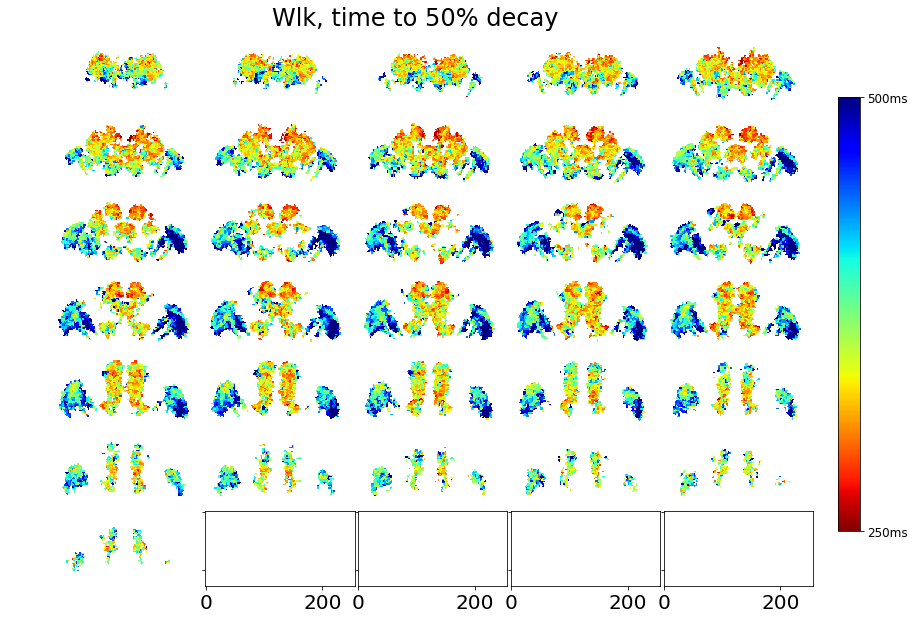

In [114]:
for beh_idx in [3]:
    behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

    add_deleted_voxels = np.zeros(62000)
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    add_deleted_voxels[to_replace] = peaks[beh_idx] - decay_times[beh_idx]#peaks[beh_idx] #cluster_ids #model.labels_ ### put signal here
    to_plot = np.reshape(add_deleted_voxels, (31,2000))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = to_plot[z-9,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    # to_plot = np.max(all_colored_by_betas, axis=0)
    # plt.imshow(to_plot[:,:].T)
    all_colored_by_betas[all_colored_by_betas==0] = np.nan

#     start = 265
#     end = 200
#     middle = 250
    
#     start = 265
#     end = 235
#     middle = 250
    
    start = 235
    end = 190
    #middle = 250

#     # sample the colormaps that you want to use. Use 128 from each so we get 256
#     # colors in total
#     colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
#     colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

#     # combine them and build a new colormap
#     colors = np.vstack((colors1, colors2))
#     mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

#     mymap.set_bad(color='grey')

    fig = plt.figure(figsize=(20,10))
    grid = ImageGrid(fig, 111, nrows_ncols=(7, 5), axes_pad=.05)
    for i in range(31):
        #cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap=mymap,vmin=end,vmax=start);
        cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap='jet_r',vmin=50,vmax=100);
        grid[i].axis('off')

    #cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
    #cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'], fontsize=12)

    cbar = fig.colorbar(cax, ticks=[50, 100],shrink=.8, anchor=(.1,.5))
    cbar.ax.set_yticklabels(['250ms', '500ms'], fontsize=12)

    plt.suptitle(f'{behs[beh_idx]}, time to 50% decay',y=.93)

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, f'{timestr}')
    #plt.savefig(fname,dpi=300,bbox_inches='tight')